In [46]:
import warnings
warnings.filterwarnings('ignore')

# CHORDS

In [47]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy import spatial

`librosa.load` загружает композицию в виде временного ряда с заданной частотой дискретизации `sr`

Для понимания процесса:

Аналоговый сигнал - непрерывен во времени, определен во все моменты; колебания напряжения, возникающие из-за колебаний мембраны в микрофоне

Чтобы превратить аналоговый сигнал в цифровой, проводится процесс дискретизации. Частота дискретизации sr - с какими интервалами по времени идут данные об уровне сигнала; глубина дискретизации - разрядность числа, которым описывается уровень сигнала

Pitch classes - набор из 12 высотных классов, соответствующих высотам нот без учета октавы (сдвиг на октаву значит умножение в 2 раза)

In [48]:
# PITCH_CLASSES = ['a', 'a#', 'b', 'c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#']
PITCH_CLASSES = ['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b']
HARMONICS_COEF = 0.5
NC_SENSITIVITY_COEF = 0.6
CHORDS_4_SENSITIVITY_COEF = 0.7

Гармоники: при звучании ноты одновременно с ней звучат ее гармоники - ноты с кратными фундаментальной ноте частотами, но меньшей интенсивности. Первые гармоники можно найти прибавлением интервалов: h1 = n + октава, h2 = h1 + чистая квинта, h3 = h2 + чистая кварта, h4 = h3 + большая терция, h5 = h4 + малая терция и т.д.

Гармоники нужны для уточнения темплейтов аккордов. к примеру аккорд CEG (C_maj) можно в идеальном виде записать как [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]. Однако на деле звучать также будут ноты, отмеченные гармониками: [1, 0, 0.6, 0, 1, ...]

In [49]:
SEVENTH = {"_dom7": (4, 7, 10), "_min7": (3, 7, 10), "_maj7": (4, 7, 11), "_half_dim7": (3, 6, 10), "_dim7": (3, 6, 9)}


def get_harmonics(mask):
    harmonics = [[1] if el == 1 else [] for el in mask]
    for i in range(len(harmonics)):
        if 1 in harmonics[i]:
            perfect_fifth = (i + 7) % 12
            perfect_fourth = (perfect_fifth + 5) % 12
            major_third = (perfect_fourth + 4) % 12

            harmonics[perfect_fifth].append(2)
            harmonics[perfect_fourth].append(3)
            harmonics[major_third].append(4)
    return harmonics


def get_weights(harmonic_array):
    np_harmonic_ar_m1 = np.array(harmonic_array) - 1
    return np.sum(HARMONICS_COEF ** np_harmonic_ar_m1)


def get_perfect_fifth_mask(main_pc_index, is_major):
    if main_pc_index >= 12:
        print('error')
        return

    if is_major:
        diff = 4
    else:
        diff = 3

    fifth = 7
    mask = [0 for _ in range(12)]
    mask[main_pc_index] = 1

    mask[(main_pc_index + fifth) % 12] = 1
    mask[(main_pc_index + diff) % 12] = 1
    return mask, PITCH_CLASSES[main_pc_index] + ("_maj" if is_major else "_min")


def get_seventh_mask(index):
    if index >= 12:
        print('error')
        return

    masks = {}
    for key, val in SEVENTH.items():
        mask = [0 for i in range(12)]

        mask[index] = 1

        for diff in val:
            mask[(index + diff) % 12] = 1

        masks[PITCH_CLASSES[index] + key] = mask
    return masks


def get_mask_with_harmonics(mask):
    harmonics = get_harmonics(mask)
    pc_weights = np.array([get_weights(harmonic) for harmonic in harmonics])

    return normalize([pc_weights], norm='max', axis=1)[0]


In [50]:
CHORDS_REVERTED = {} # mapping mask to chord name
BASE_MASKS = {} # chord name to raw mask (without harmonics)
for index in range(12):
    min_triad, name_1 = get_perfect_fifth_mask(index, True)
    maj_triad, name_2 = get_perfect_fifth_mask(index, False)
    
    BASE_MASKS[name_1] = min_triad
    BASE_MASKS[name_2] = maj_triad
    
    min_triad_h = get_mask_with_harmonics(min_triad)
    maj_triad_h = get_mask_with_harmonics(maj_triad)
    
    CHORDS_REVERTED[tuple(min_triad_h.tolist())] = name_1
    CHORDS_REVERTED[tuple(maj_triad_h.tolist())] = name_2
    
    # sevenths = get_seventh_mask(index)
    # CHORDS_REVERTED.update({tuple(get_mask_with_harmonics(val).tolist()) : key for key, val in sevenths.items()})
    # BASE_MASKS.update(sevenths)
    
no_chord = [1] * 12
BASE_MASKS['N'] = no_chord
CHORDS_REVERTED[tuple(no_chord)] = 'N'

In [51]:
{val: key for key, val in CHORDS_REVERTED.items()}["c_maj"]

(0.7142857142857143,
 0.0,
 0.2857142857142857,
 0.0,
 0.7857142857142857,
 0.0,
 0.0,
 1.0,
 0.07142857142857142,
 0.0,
 0.0,
 0.35714285714285715)

In [52]:
def print_chord(mask):
    return CHORDS_REVERTED[mask]

In [53]:
def sort_index(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s

def n_max_els(lst, n):
    if (n <= len(lst)):
        return sort_index(lst)[:n]
    return lst


In [54]:
def plt_chord_masks(cols):
    chords = list(CHORDS_REVERTED.keys())
    rows = len(chords) // cols
    fig, axs = plt.subplots(rows, cols)
    fig.set_figheight(60)
    fig.set_figwidth(60)

    index = 0
    for row in range(rows):
        for col in range(cols):
            if index >= len(chords) - 1:
                break
            axs[row, col].bar(PITCH_CLASSES, chords[index])
            axs[row, col].set_title(print_chord(chords[index]))
            index += 1

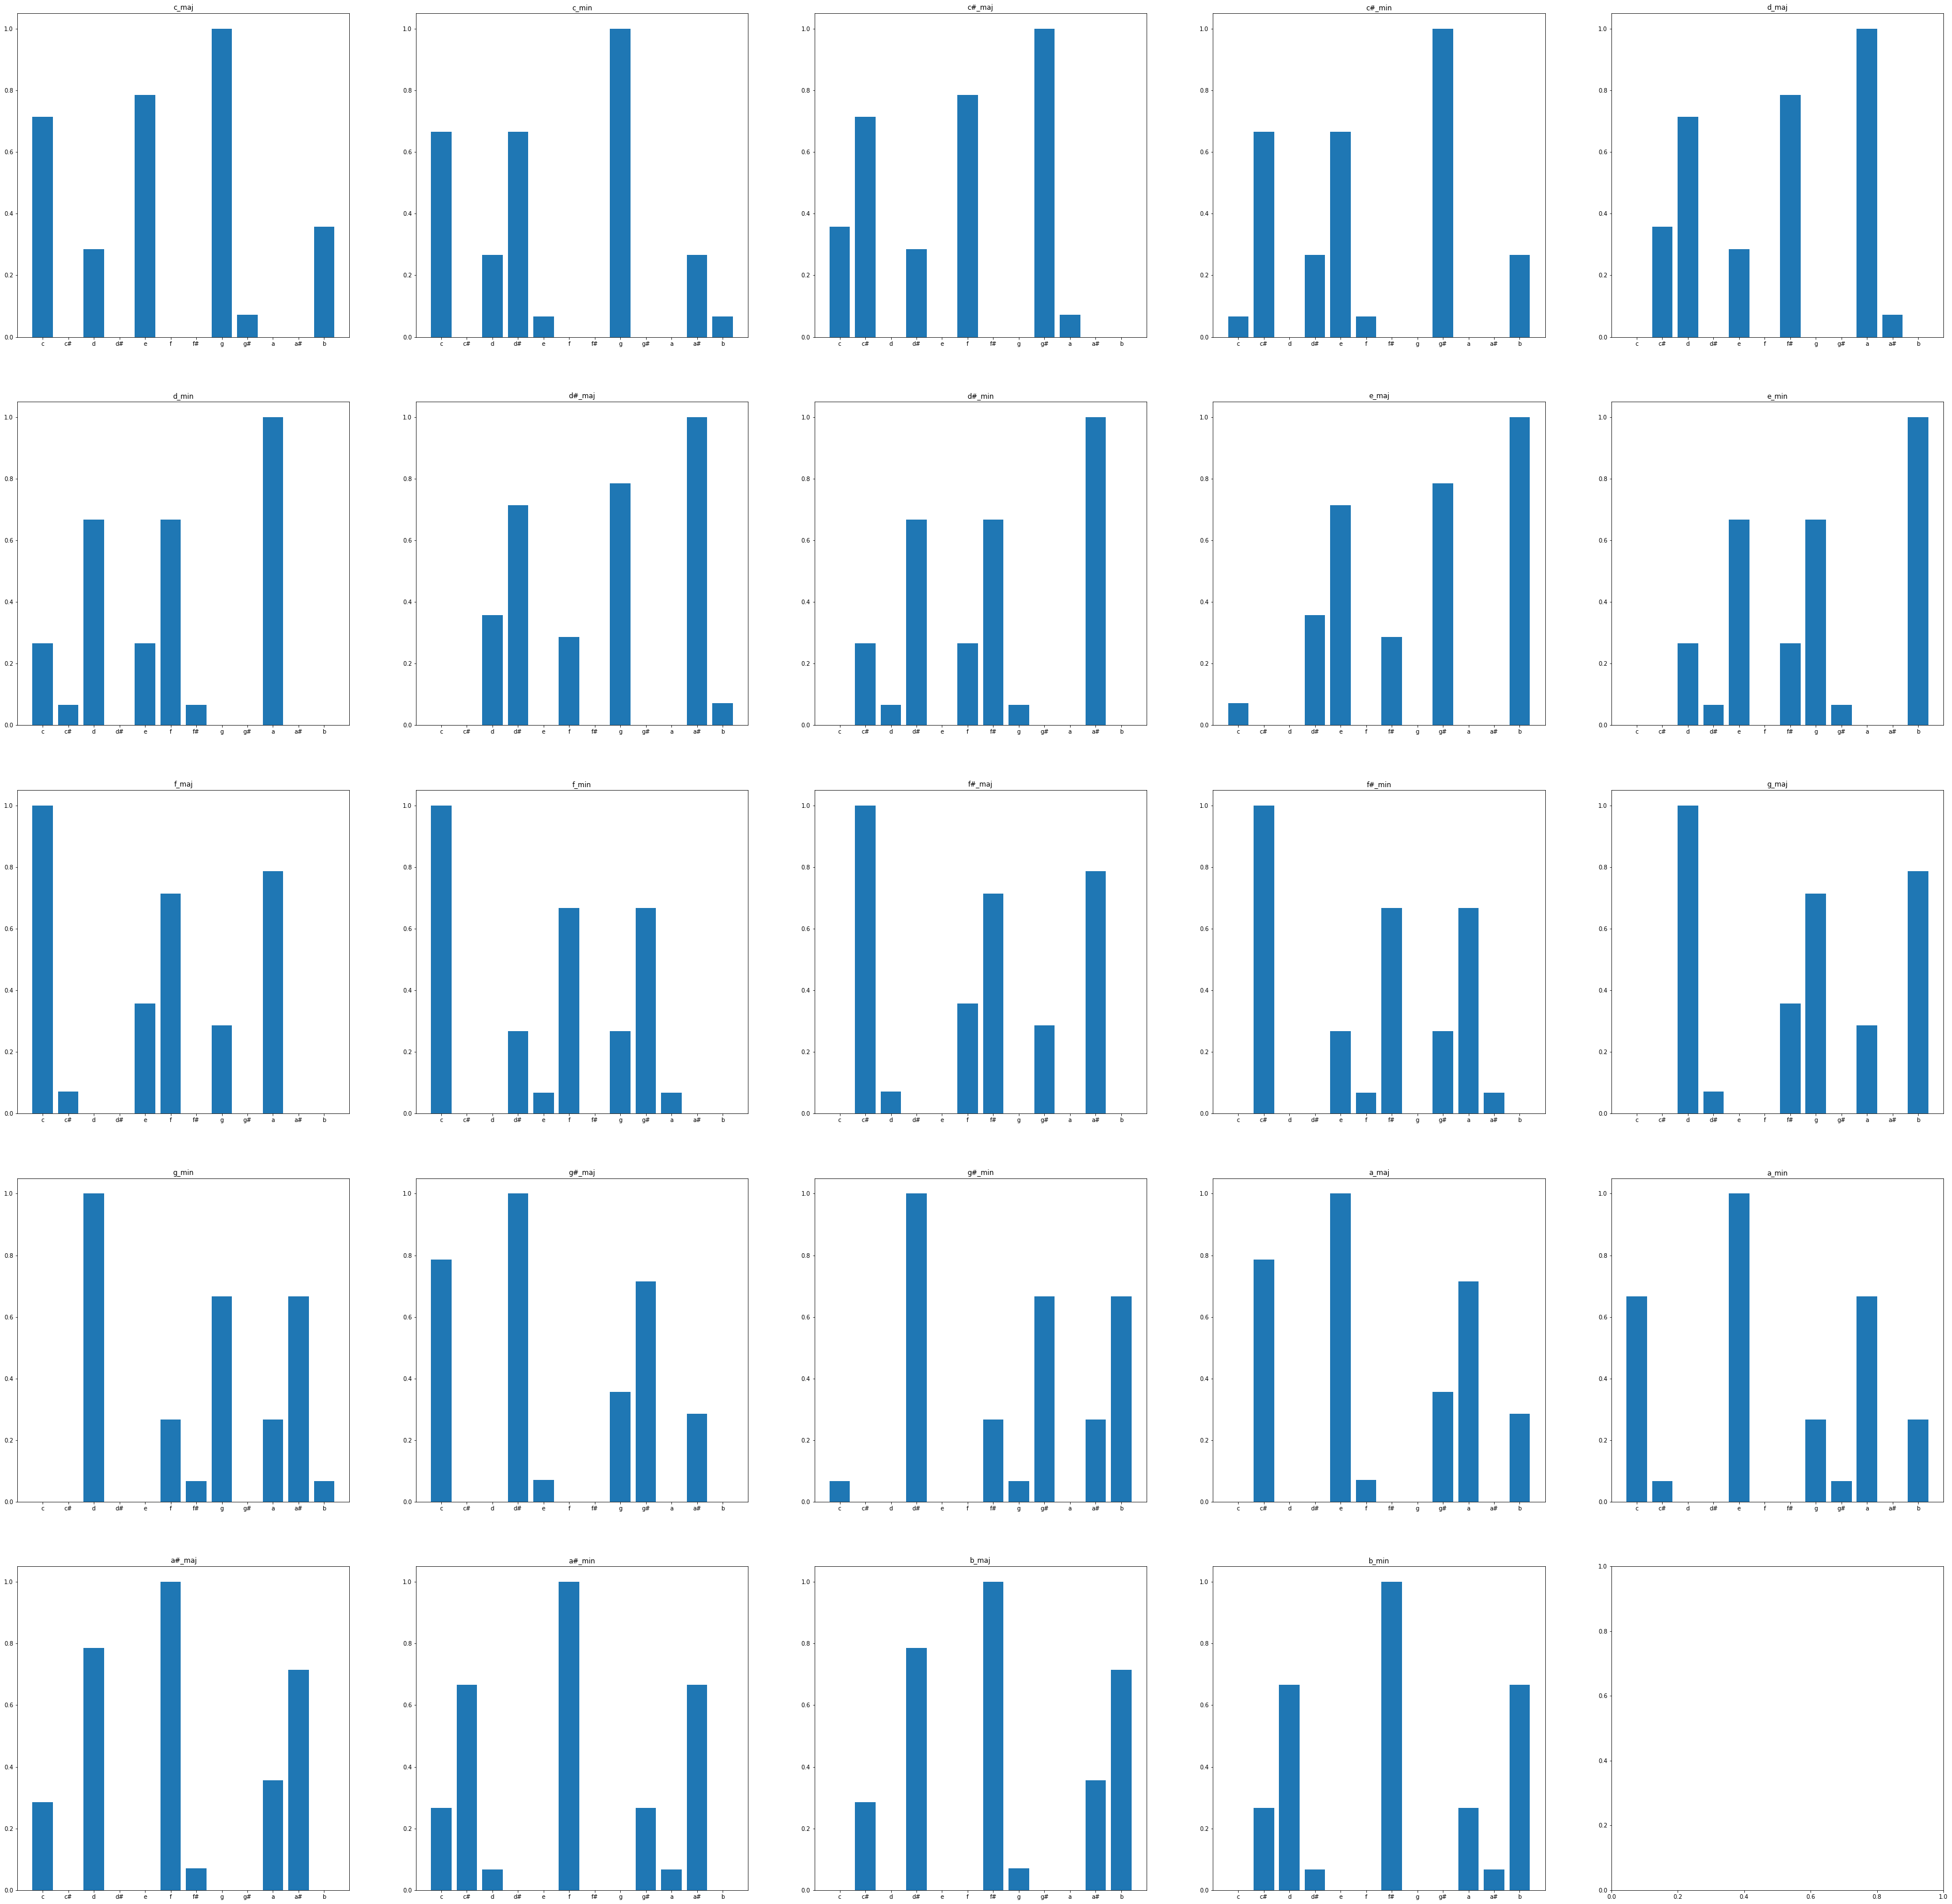

In [55]:
plt_chord_masks(5)

При процессинге композиции сначала она загружается с помощью librosa в формате временного ряда. Затем для композиции находятся точки, на которые выпадают "биения" или beats - по-простому это точки, в которых слушатель мог бы "притопывать ногой"; доказано, что именно в точках beats вероятнее всего смена аккорда. Далее для композиции находятся "вектора цветности", или PCP. Уже эти вектора сравниваются с подсчитанными масками и таким образом находится ближайший к звучащему аккорд.

In [56]:
def process_composition_librosa(path):
    y, sr = librosa.load(path, sr=44000)
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    return beats, chroma_stft

def get_chords_per_frame(chroma_stft, beats):
    chroma_chords = np.split(chroma_stft, beats)

    chords_masks = list(CHORDS_REVERTED.keys())
    chords = []
    for chroma in chroma_chords:
        if len(chroma) == 0:
            continue
        vector = normalize([np.mean(chroma, axis=0)], axis=1, norm='max')[0]
        max_sim = 0
        probable_mask = print_chord(chords_masks[0])
        for mask in chords_masks:
            sim = 1 - spatial.distance.cosine(mask, vector)
            if np.all(np.array(mask) == 1):
                sim *= NC_SENSITIVITY_COEF  # sensitivity tuning
            if "7" in print_chord(mask):
                sim *= CHORDS_4_SENSITIVITY_COEF
            if sim > max_sim:
                max_sim = sim
                probable_mask = print_chord(mask)
        chords.append(probable_mask)
    return chords

def process_composition(path):
    beats, chroma_stft = process_composition_librosa(path)
    return get_chords_per_frame(chroma_stft.T, beats)

def process_composition_from_dataset(chroma, beats):
    return get_chords_per_frame(chroma, beats)

# SIMPLICIAL COMPLEX

In [57]:
from simplicial import *
from collections import Counter
import itertools
from sympy import *
import operator

In [58]:
FREQ_FILTRATION_STEP = 0.005

Для полученных аккордов строится фильтрованный симплициальный комплекс. Фильтрация происходит в зависимости от частотности аккорда в композиции: в первый комплекс фильтрации попадают только самые частотные аккорды, далее с шагом фильтрации в 0.005 рассматриваются все менее и менее частотные, пока не получим комплекс, содержащий в себе все аккорды.

In [59]:
def get_combinations(lst):
    combs = []
    for r in range(1, len(lst) + 1):
        combs.extend(itertools.combinations(lst, r))
    return combs

In [60]:
def get_simplices(chord):
    mask = BASE_MASKS[chord]
    pitch_classes = np.array(PITCH_CLASSES)[np.where(np.array(mask) == 1)[0]]

    combinations = get_combinations(pitch_classes)
    intervals = [tuple(sorted(x)) for x in combinations if len(x) == 2]
    triads = [tuple(sorted(x)) for x in combinations if len(x) == 3]

    return [(x,) for x in pitch_classes], intervals, triads


def count_freq(chords):
    chords_cnt = dict(Counter(chords))

    pc_freq_dict = {}
    intervals_freq_dict = {}
    triads_freq_dict = {}

    for chord in chords:
        pitch_classes, intervals, triads = get_simplices(chord)
        cnt = chords_cnt[chord]
        for pc in pitch_classes:
            pc_freq_dict[pc] = pc_freq_dict.get(pc, 0) + cnt
        for interval in intervals:
            intervals_freq_dict[interval] = intervals_freq_dict.get(interval, 0) + cnt
        for triad in triads:
            triads_freq_dict[triad] = triads_freq_dict.get(triad, 0) + cnt

    total_triads_cnt = sum(triads_freq_dict.values())

    pc_freq_dict = {key: value / total_triads_cnt for key, value in pc_freq_dict.items()}
    intervals_freq_dict = {key: value / total_triads_cnt for key, value in intervals_freq_dict.items()}
    triads_freq_dict = {key: value / total_triads_cnt for key, value in triads_freq_dict.items()}

    freq_dict = {}
    freq_dict.update(pc_freq_dict)
    freq_dict.update(intervals_freq_dict)
    freq_dict.update(triads_freq_dict)

    return freq_dict

In [61]:
def get_filtration_step(d, a_max, a):
    a1 = a_max // d * d
    an = a // d * d

    return round((an - a1) / (-d) + 1)


def get_filtration_for_frequencies(frequencies, d):
    max_el = max(frequencies.values())
    filtration_dict = {}
    for key, val in frequencies.items():
        filtration_step = get_filtration_step(d, max_el, val)
        if filtration_step in filtration_dict:
            filtration_dict[filtration_step].append(key)
        else:
            filtration_dict[filtration_step] = [key]
    return filtration_dict


def get_filtration_by_freq(chords):
    frequencies = count_freq(chords)
    simplices_by_step = sorted(get_filtration_for_frequencies(frequencies, FREQ_FILTRATION_STEP).items(),
                               key=lambda x: x[0])

    filtration = Filtration()

    for step in simplices_by_step:
        filtration.setIndex(step[0])

        simplices = step[1]
        simplices.sort()  # sort alphabetically
        simplices.sort(key=len)  # sort by length

        for simplex in simplices:
            id = "".join(simplex)
            if len(simplex) == 1:
                filtration.addSimplex(id=id)
            elif len(simplex) == 2:
                filtration.addSimplex(id=id, fs=simplex)
            else:
                fs = set(["".join(sorted([simplex[i - 1], simplex[i]])) for i in range(len(simplex))])
                filtration.addSimplex(id=id, fs=fs)

    return filtration


К столбцам полученной матрицы применяется алгоритм Гаусса (для приведения матрицы к ступенчатому виду). 

Последовательно рассматриваются столбцы слева направо. 

low(x) – номер строки самого нижнего ненулевого элемента в столбце x

Если слева от текущего столбца x найдётся столбец y, что low(x) = low(y), то он, домноженный на соответствующий коэффициент, вычитается из x, тем самым low(x) уменьшается 

Это повторяется для текущего x, до тех пор, пока находится столбец y

In [62]:
def last_index_of(lst, value):
    return len(lst) - operator.indexOf(reversed(lst), value) - 1

In [63]:
def last_index_of(lst, value):
    return len(lst) - operator.indexOf(reversed(lst), value) - 1


def get_low(column):
    if 1 in column:
        low = last_index_of(column, 1)
    else:
        low = -1
    return low


def get_gauss_form(matrix):
    left_low_els = []
    for col in range(len(matrix)):
        column = matrix[col]
        low = get_low(column)
        while low != -1 and low in left_low_els:
            column_to_distract = operator.indexOf(left_low_els, low)
            column = (column - matrix[column_to_distract]) % 2
            low = get_low(column)
        matrix[col] = column
        left_low_els.append(low)
    return matrix.T


def get_simplices_of_order(filtration, order):
    simplices = []
    simplices_of_order_set = filtration.simplicesOfOrder(order)
    for simplex in filtration.simplices():
        if simplex in simplices_of_order_set:
            simplices.append(simplex)
    return simplices

In [64]:
def compute_persistence(filtration, k=1):
    gaussian_form = get_gauss_form(filtration.boundaryOperator(k=k).T)
    low_indexes = {i: get_low(gaussian_form[:, i]) for i in range(gaussian_form.shape[1])}

    simplices_k = get_simplices_of_order(filtration, k)
    simplices_km1 = get_simplices_of_order(filtration, k - 1)

    pairs = [(simplices_k[key], simplices_km1[val]) for key, val in low_indexes.items() if val != -1]

    return np.array(list(filter(lambda x: x[0] != x[1], 
                                [[filtration.addedAtIndex(pair[1]), filtration.addedAtIndex(pair[0])] for pair in pairs])))

In [65]:
f = Filtration()

filtration_simplices = {'0': ['1', '2', '3', '4'], '1': ['13', '24', '12', '34', '14', '23'], '2': ['123', '124', '134', '234'], '3': ['1234']}

f.setIndex(0.0)
f1 = f.addSimplex(id='1')
f2 = f.addSimplex(id='2')
f3 = f.addSimplex(id='3')
f4 = f.addSimplex(id='4')

f.setIndex(1.0)
f13 = f.addSimplex(id='13', fs=[f1, f3])
f24 = f.addSimplex(id='24', fs=[f2, f4])

f.setIndex(2.0)
f12 = f.addSimplex(id='12', fs=[f1, f2])
f34 = f.addSimplex(id='34', fs=[f3, f4])

f.setIndex(3.0)
simplices = get_combinations(['1','2','3','4'])
for simplex in simplices:
    id = "".join(simplex)
    if not f.containsSimplex(id):
        f.addSimplexWithBasis(id=id, bs=simplex)

Граничный оператор показывает, какие (k-1)-симплексы являются гранями k-симплексов. Это матрица, в которой колонки обозначают k-симплексы, строки - (k-1)-симплексы. Так, в матрице ниже 1 на пересечении 1 и 13 симплексов означает, что 1 входит в симплекс 13 как грань.

\begin{equation} 
\begin{bmatrix}
& | & 13 & 24 & 12 & 34 & 14 & 23 \\
\hline
1 & | & 1 & 0 & 1 & 0 & 1 & 0 \\
2 & | & 0 & 1 & 1 & 0 & 0 & 1 \\
3 & | & 1 & 0 & 0 & 1 & 0 & 1 \\
4 & | & 0 & 1 & 0 & 1 & 1 & 0
\end{bmatrix}
\end{equation}

In [66]:
f.boundaryOperator(k=1)

array([[1, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 0]], dtype=int8)

In [67]:
compute_persistence(f, k=3)

array([], dtype=float64)

In [68]:
compute_persistence(f, k=2)

array([[2., 3.]])

# EXPERIMENTS

## Chords recognition

### Cross-composer dataset

In [69]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations


In [70]:
chroma_bach = pd.read_csv('/Users/stacy-zlato/Documents/вкр/cross-composer_chroma-nnls/chroma-nnls_01_bach.csv')
chords_bach = pd.read_csv('/Users/stacy-zlato/Documents/вкр/cross-composer_chords-chordino/chords-chordino_01_bach.csv')

In [71]:
def prepare_chords_dataset(path):
    df = pd.read_csv(path)

    df_list = np.split(df, df[df.notnull().all(1)].index)
    
    result = []

    for df in df_list:
        df = df.drop(df[df.notnull().all(1)].index)
        result.append(df.iloc[:, 1:])
    return result

In [72]:
chords_df = prepare_chords_dataset('/Users/stacy-zlato/Documents/вкр/cross-composer_chords-chordino/chords-chordino_01_bach.csv')
chroma_features_df = prepare_chords_dataset('/Users/stacy-zlato/Documents/вкр/cross-composer_chroma-nnls/chroma-nnls_01_bach.csv')

- Получить фичи и прогнать через пайплайн с битами = фреймы аккордов, получить список аккордов
- Получить аккорды
- Прогнать CountVectorizer
- посчитать косинусное расстояние векторов CV

In [73]:
def process_df_features(df_chroma, df_chords):
    chroma_features_time = (df_chroma.iloc[:,0].values * 10).astype(int)
    chords_time = (df_chords.iloc[:,0].values * 10).astype(int)
    
    beats = np.where(np.isin(chroma_features_time, chords_time))
    chroma = df_chroma.iloc[:, 1:].to_numpy()
    # в работе используется гамма C, C#, D, ..., B, а в датасете - A, A#, B, ..., G#, поэтому нужен сдвиг с np.roll(ax, shift)
    return beats[0], np.roll(chroma, 9) 

In [74]:
def get_prev_pc(pc):
    chords = 'ABCDEFG'
    index = operator.indexOf(chords, pc)
    return chords[index - 1]
    
def get_triad(chord):
    matcher = re.search("^(.*?_\w{3})_\w{3}7$", chord)
    if matcher:
        triad = matcher.group(1)
    else:
        triad = chord
    main_pc = re.search("^(\w)b", triad)
    if main_pc:
        return re.sub("^\wb", get_prev_pc(main_pc.group(1)) + "#", triad).lower()
    return triad.lower()

def process_df_chords_as_triads(df_chords):
    chords = [get_triad(chord) for chord in df_chords.iloc[:, 1].tolist()]
    return chords

In [75]:
def get_chords_to_compare(df_chroma, df_chords):
    beats, chroma = process_df_features(df_chroma, df_chords)
    chords_precalculated = process_df_chords_as_triads(df_chords)
    
    chords = process_composition_from_dataset(chroma, beats)
    
    return chords, chords_precalculated

In [76]:
chords, expected = get_chords_to_compare(chroma_features_df[48], chords_df[48])

In [77]:
chords_matrix = []
expected_matrix = []

for i in trange(len(chroma_features_df)):
    chords, expected = get_chords_to_compare(chroma_features_df[i], chords_df[i])
    
    chords_matrix.append(" ".join(chords))
    expected_matrix.append(" ".join(expected))
    
vectorizer = CountVectorizer(stop_words=None, token_pattern=r'\w#?_\w{3}7?', analyzer='word')
vectorizer.fit(chords_matrix + expected_matrix)

X = vectorizer.transform(chords_matrix)
Y = vectorizer.transform(expected_matrix)

  0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = [1 - spatial.distance.cosine(X.toarray()[i], Y.toarray()[i]) for i in range(len(X.toarray()))]

In [79]:
np.mean(similarities)

0.9342912335127482

### GuitarSet dataset

In [80]:
import os

In [81]:
path = "/Users/stacy-zlato/Documents/вкр/PAGCD/audio_filtered/triads"

In [82]:
dataset_files = sorted(os.listdir(path))

In [83]:
def get_chord_from_guitarset_file(file):
    matcher = re.search(r'^(\w#?)(\w{3}).wav$', file)
    if matcher:
        return matcher.group(1) + "_" + matcher.group(2)

file_to_chord = {os.path.join(path, file): get_chord_from_guitarset_file(file) for file in dataset_files}

In [84]:
def process_guitar_set_audio(path, chord):
    chords = np.array(process_composition(path))
    errors_cnt = len(np.where(chords != chord))
    chords_cnt = len(chords)
    return chords_cnt, errors_cnt

In [85]:
total_cnt = 0
errors_cnt = 0

for path, chord in tqdm(file_to_chord.items()):
    total, errors = process_guitar_set_audio(path, chord)
    total_cnt += total
    errors_cnt += errors
    
accuracy = (total_cnt - errors_cnt) / total_cnt

  0%|          | 0/24 [00:00<?, ?it/s]

In [86]:
accuracy

0.9838383838383838

## Topological representation

In [87]:
import PersistenceImages.persistence_images as pimg

In [90]:
path = "/Users/stacy-zlato/Documents/вкр/tlsp-eycte.wav"
chords = process_composition(path)

In [91]:
filtration = get_filtration_by_freq(chords)

In [92]:
filtration.simplicesOfOrder(0)

{'a', 'a#', 'b', 'c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#'}

In [96]:
pers = compute_persistence(filtration, k=2)

In [99]:
pers_imager = pimg.PersistenceImager()
pers_imager.fit([pers], skew=True)

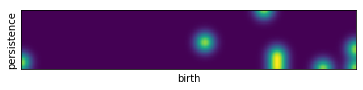

In [100]:
pers_imager.plot_image(pers, skew=True)

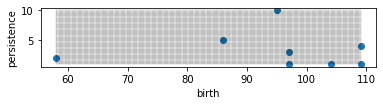

In [101]:
pers_imager.plot_diagram(pers, skew=True)

In [105]:
pers

array([[ 58,  60],
       [ 86,  91],
       [ 97,  98],
       [ 97, 100],
       [ 95, 105],
       [104, 105],
       [109, 110],
       [109, 113]])

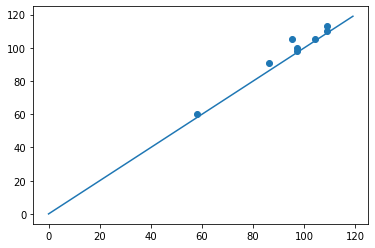

In [107]:
plt.scatter(pers[:, 0], pers[:, 1])
plt.plot([i for i in range(120)], [i for i in range(120)])
plt.show()